In [12]:
# ---------- SECOND LEVEL ANALYSIS ------------
# ---------------- Rat HRF -------------------

#Imports

import os
import glob
import nilearn 
import itertools
import numpy as np 
import pandas as pd
import nibabel as nib

from numpy import savetxt
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.glm import threshold_stats_img
from nilearn.image import get_data, math_img
from nilearn import plotting, image, datasets
from nilearn.plotting import plot_design_matrix
from nilearn.datasets import fetch_localizer_contrasts
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix

# Init variables
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder="/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/"
z_scores_path = "/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/z_score/"
beta_path = "/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/beta_estimates/"

# Data path
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path = '/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'

# Paths for the directories
output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/second_level/'
rat_hrf_gamma_diff_dir =  os.path.join(output_dir, 'rat_hrf_gamma_diff/')
rat_hrf_delay_disp_dir = os.path.join(output_dir, 'rat_hrf_delay_disp/')

gamma_image_dir = os.path.join(rat_hrf_gamma_diff_dir, 'image/')
gamma_beta_dir = os.path.join(rat_hrf_gamma_diff_dir, 'beta_estimates/')
gamma_z_score_dir = os.path.join(rat_hrf_gamma_diff_dir, 'z_score/')
gamma_p_value_dir = os.path.join(rat_hrf_gamma_diff_dir, 'p_value/')
gamma_clusters_dir = os.path.join(rat_hrf_gamma_diff_dir, 'clusters/')

dd_image_dir = os.path.join(rat_hrf_delay_disp_dir, 'image/')
dd_beta_dir = os.path.join(rat_hrf_delay_disp_dir, 'beta_estimates/')
dd_z_score_dir = os.path.join(rat_hrf_delay_disp_dir, 'z_score/')
dd_p_value_dir = os.path.join(rat_hrf_delay_disp_dir, 'p_value/')
dd_clusters_dir = os.path.join(rat_hrf_delay_disp_dir, 'clusters/')

if not os.path.exists(output_dir): os.makedirs(output_dir)
if not os.path.exists(rat_hrf_gamma_diff_dir): os.makedirs(rat_hrf_gamma_diff_dir)
if not os.path.exists(rat_hrf_delay_disp_dir): os.makedirs(rat_hrf_delay_disp_dir)
if not os.path.exists(gamma_image_dir): os.makedirs(gamma_image_dir)
if not os.path.exists(gamma_beta_dir): os.makedirs(gamma_beta_dir)
if not os.path.exists(gamma_z_score_dir): os.makedirs(gamma_z_score_dir)
if not os.path.exists(gamma_p_value_dir): os.makedirs(gamma_p_value_dir)
if not os.path.exists(gamma_clusters_dir): os.makedirs(gamma_clusters_dir)
if not os.path.exists(dd_image_dir): os.makedirs(dd_image_dir)
if not os.path.exists(dd_beta_dir): os.makedirs(dd_beta_dir)
if not os.path.exists(dd_z_score_dir): os.makedirs(dd_z_score_dir)
if not os.path.exists(dd_p_value_dir): os.makedirs(dd_p_value_dir)
if not os.path.exists(dd_clusters_dir): os.makedirs(dd_clusters_dir)


df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')] 

In [15]:
# --- Input data ---

""" Define hrf model used for the first analysis
    Options : 
    ---------
    rat_hrf_delay_disp
    rat_hrf_gamma_diff
"""
#hrf_function = 'rat_hrf_gamma_diff'
hrf_function = 'rat_hrf_delay_disp'

First level analysis used: rat_hrf_delay_disp
ID: 02001
number of subjects: 10


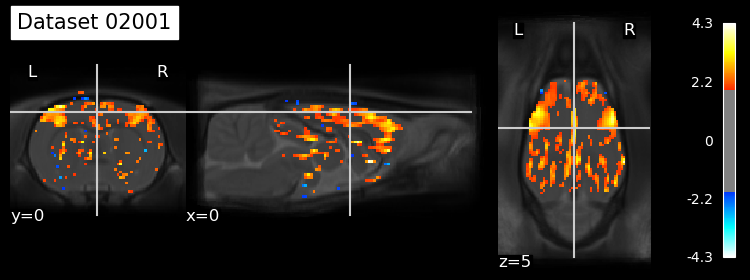

In [14]:
# ---------- SECOND LEVEL ANALYSIS ------------
# ---------------- Rat HRF -------------------

print('First level analysis used:', hrf_function)

for index in range(1, 2):
    
    ID = "0"+str(2000+index)
    print("ID:", ID)
    
    # -- Load data --
    if hrf_function == 'rat_hrf_gamma_diff':
        dataset = glob.glob(analysis_folder+'rat_hrf_gamma_diff/beta_estimates/beta_sub-{}??_ses-1.nii.gz'.format(ID))
    
    elif hrf_function == 'rat_hrf_delay_disp':
        dataset = glob.glob(analysis_folder+'rat_hrf_delay_disp/beta_estimates/beta_sub-{}??_ses-1.nii.gz'.format(ID))
    
    else:
        print('No file to be saved. Check that hrf_function is well defined.')
        
    
    n_subject = len(dataset)                                                           
    print("number of subjects:", n_subject)

    second_level_input = dataset
    design_matrix = pd.DataFrame([1] * len(second_level_input), 
                                columns=["intercept"])
    
    # --- Specify the model and fit it --- 
    second_level_model = SecondLevelModel(smoothing_fwhm=0.1,
                                          minimize_memory=False)        #if want to get residuals?

    second_level_model = second_level_model.fit(second_level_input,
                                                design_matrix=design_matrix)


    # --- Estimate the contrast --- 
    second_stat_map = second_level_model.compute_contrast(second_level_contrast='intercept', output_type='all') 

    p_val = 0.05
    plot_stat = plotting.plot_stat_map(second_stat_map['z_score'],
                                        bg_img = template_path,
                                        threshold = 1.9,              #threshold p=p_val=0.05 uncorrected -> reduces false negative levels
                                        cut_coords= (0 ,0, 5.5),        
                                        display_mode='ortho',
                                        draw_cross=True,
                                        colorbar=True,
                                        title="Dataset {}".format(ID))

    #plt.savefig(image_dir+'stat_map_dataset-{}_z_score.png'.format(ID)) 
    
    
    #-- Save output --  
    if hrf_function == 'rat_hrf_gamma_diff':
        #nib.save(second_stat_map['z_score'], gamma_z_score_dir+'z_score_dataset-{}.nii.gz'.format(ID))          #save z_score map
        nib.save(second_stat_map['effect_size'], gamma_beta_dir+'beta_dataset-{}.nii.gz'.format(ID))            #save the beta estimates
        #nib.save(second_stat_map['p_value'], gamma_p_value_dir+'p_value_dataset-{}.nii.gz'.format(ID))          #save the p_value
        plt.savefig(gamma_image_dir+'stat_map_dataset-{}_z_score.png'.format(ID)) 
   
    elif hrf_function == 'rat_hrf_delay_disp':
        #nib.save(second_stat_map['z_score'], dd_z_score_dir+'z_score_dataset-{}.nii.gz'.format(ID))          #save z_score map
        nib.save(second_stat_map['effect_size'], dd_beta_dir+'beta_dataset-{}.nii.gz'.format(ID))            #save the beta estimates
        #nib.save(second_stat_map['p_value'], dd_p_value_dir+'p_value_dataset-{}.nii.gz'.format(ID))          #save the p_value
        plt.savefig(dd_image_dir+'stat_map_dataset-{}_z_score.png'.format(ID)) 

    else:
        print('No file to be saved. Check that hrf_function is well defined.')
        

